In [1]:
import utils as u

from matplotlib.pyplot import *
import matplotlib as mpl
import os

from scipy.fft import *
from scipy.special import jv
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error
from scipy.interpolate import UnivariateSpline
import numpy as np

import numba
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# Constants and parameters

In [7]:
# Constants
nu_darkring = 1.22*np.pi  # location of first airy ring minimum
n  = 16                   # N_{Rayleigh} (i.e. number of nu_darkring's to plot)
o = 1                     # bessel function order

n_r = 256                 # N_{Airy} (i.e. number of pixels between peak and first min)
N = n*n_r*2               # size of array and bessel function
N_na = 1.22*(N/2)/n_r     # radius of aperture
# b = .5                  # fractional diameter of central stop

airy_1 = np.linspace(-nu_darkring,nu_darkring,n_r*2)       # domain of first airy ring
airy_n = np.linspace(-nu_darkring*n,nu_darkring*n,n_r*n*2) # domain of nth airy ring

downscale_factor = 32     # Degree of downscaling to smooth aperture edge

# psf of circular aperture
psf = lambda o,v: (2*jv(o,v)/v)**2 

# psf of circular aperture with center stop
psf_c = lambda o,v,b: (1/(1-b**2))**2*\
                      (2*jv(o,v)/v-b**2*2*jv(o,v*b)/(v*b))**2

print('Array size =',str(N)+'x'+str(N), '\n',
      '\rAperature radius =',N_na, '\n')

Array size = 8192x8192 
Aperature radius = 19.52 



# Run simulation

In [3]:
b_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]                     # list of values for b to loop through.

Num_shifts = 33
shifts = np.linspace(0,1*N_na*downscale_factor, Num_shifts).astype(int)    # list of distances to shift the central stop.
shifts_percent = shifts/downscale_factor/N_na
nu_b_darkring = [3.786,3.664,3.502,3.322,3.144,2.974,2.814,2.666,2.53]     # list of locations of first dark ring for corresponding b.

data_dic = {}
for i, b in enumerate(b_list):
    FWHM = []
    central_peak_sum = []
    # Mask to isolate the central ring by selecting only pixels inside n_b_darkring
    central_peak_mask = (np.sum((np.mgrid[0:N,0:N]-N/2)**2, axis = 0)**.5)<(n_r*nu_b_darkring[i]/nu_darkring) 
    for j, shift in enumerate(shifts):
        print('b:',i+1,'/',len(b_list), ' '*4+'s:',j+1,'/',Num_shifts, end = '     \r')
        # Generate aperture w/ central stop and diffraction pattern
        a_cs = u.create_aperture(aperture_radius = N_na, array_size = N,
                                 downscale_factor = downscale_factor, b = b, shift = shift)
        A_cs_comp = fftshift(fft2(a_cs, workers=-1), axes = (0,1))
        A_cs = abs2(A_cs_comp)
        A_cs_phase = np.angle(A_cs_comp)
        central_peak_sum.append(np.sum(A_cs[central_peak_mask])/np.sum(A_cs))
        spline = UnivariateSpline(airy_n, A_cs[A_cs.shape[0]//2,:]-A_cs[A_cs.shape[0]//2,:].max()/2, s = 0)
        r1, r2 = spline.roots()
        FWHM.append(r2-r1)
    
    data_dic[b] = {'FWHM': FWHM, 'CPS': central_peak_sum, 'SP': shifts_percent}
print('DONE '*10)

DONE DONE DONE DONE DONE DONE DONE DONE DONE DONE 


# Plot data

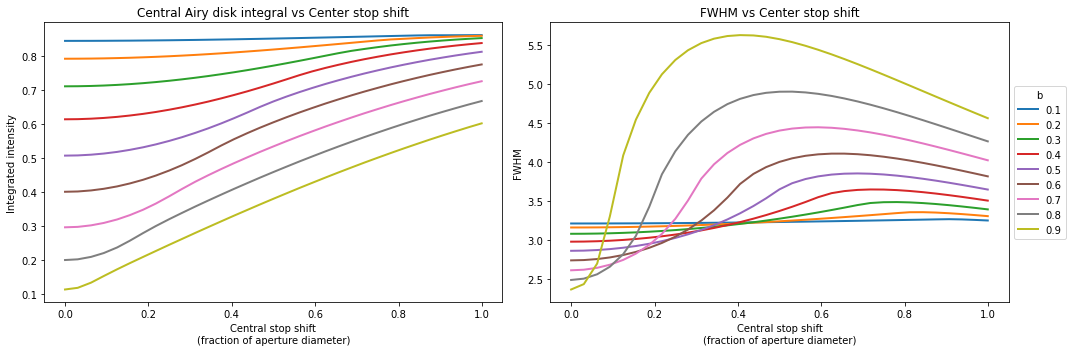

In [9]:
fig, axes = subplots(1,2, figsize = (15,5), facecolor = 'white')
mpl.rcParams['lines.linewidth'] = 2
for i, b in enumerate(b_list):
    FWHM = []
    central_peak_sum = []
    data = data_dic[b]
    axes[0].plot(data['SP'], data['CPS'], zorder = 0)
    axes[1].plot(data['SP'], data['FWHM'], zorder = 0, label = np.round(b,2))
    
axes[1].set_ylabel('FWHM')
axes[1].set_xlabel('Central stop shift\n(fraction of aperture diameter)')
axes[0].set_ylabel('Integrated intensity')
axes[0].set_xlabel('Central stop shift\n(fraction of aperture diameter)')
axes[1].legend(title = 'b', loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_title('Central Airy disk integral vs Center stop shift')
axes[1].set_title('FWHM vs Center stop shift')
tight_layout()
savefig('./FWHM_Sum_vs_Shift.pdf')
show()
    